# Multidimensional scaling

Some notes I've discovered during my search for Instagram user distance.

Visualisations based on https://www.de.dariah.eu/tatom/working_with_text.html#visualizing-distances.


In [1]:
import psycopg2
import psycopg2.extras

import psycopg2.extensions
psycopg2.extensions.register_type(psycopg2.extensions.UNICODE)
psycopg2.extensions.register_type(psycopg2.extensions.UNICODEARRAY)

conn = psycopg2.connect("dbname=instagram_lda user=stlk")
cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)

cur.execute("SELECT raw_text, username FROM media")
data = cur.fetchall()
media = map(lambda i: i[0], data)
usernames = map(lambda i: i[1], data)

### Generate document-term matrix

In [2]:
import numpy as np # a conventional alias

import sklearn.feature_extraction.text as text

vectorizer = text.CountVectorizer(input='content', strip_accents='ascii', stop_words='english', min_df=20)

dtm = vectorizer.fit_transform(media).toarray()

vocab = np.array(vectorizer.get_feature_names())

### user similarity

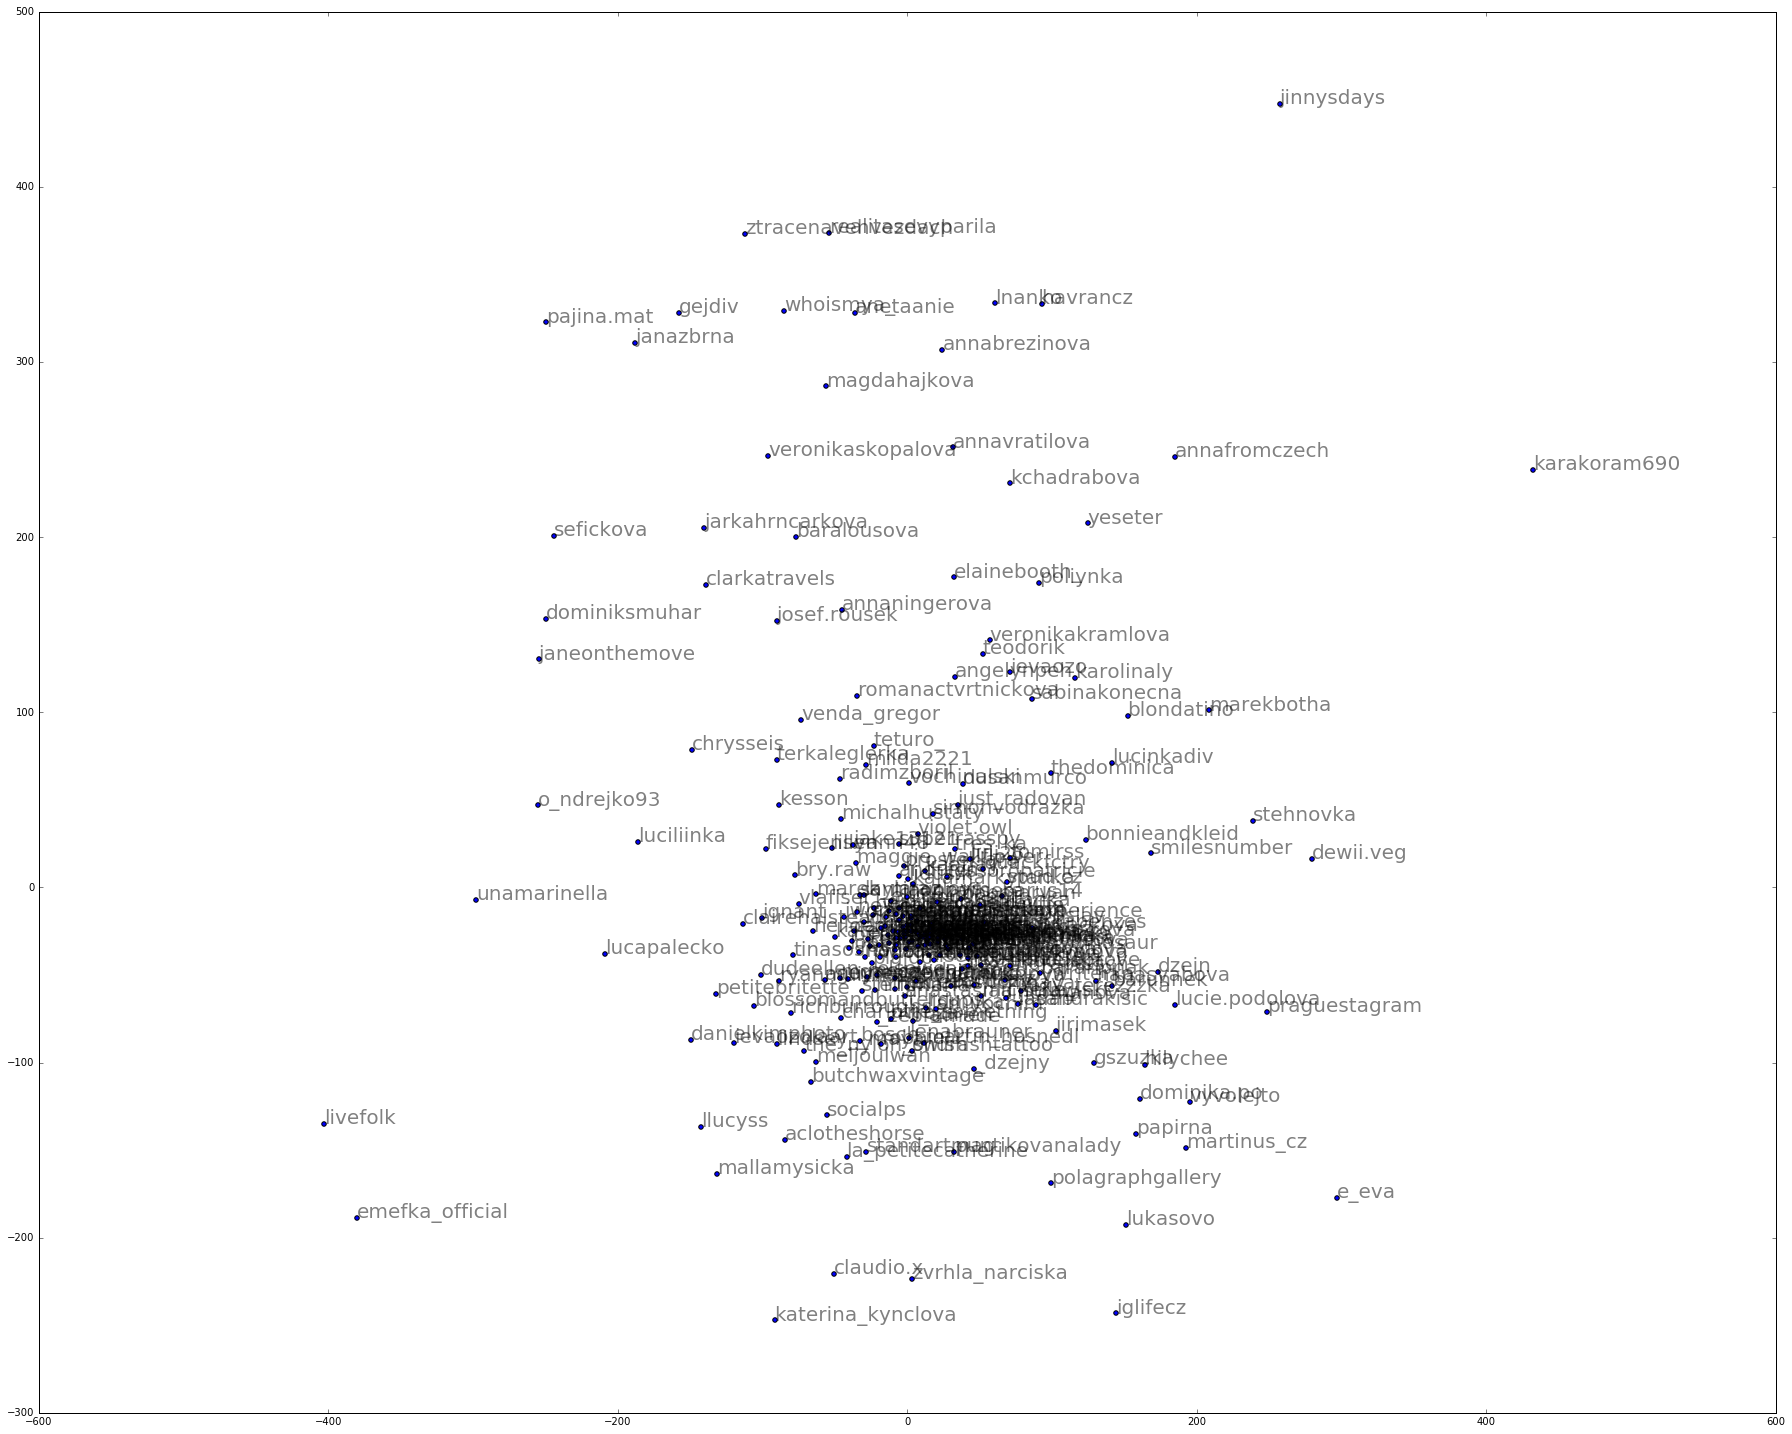

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import MDS

from sklearn.metrics.pairwise import cosine_similarity

mds = MDS(n_components=2, dissimilarity="euclidean", random_state=1)
pos = mds.fit_transform(dtm)  # shape (n_components, n_samples)

plt.figure(figsize=(25, 20))  # use a bigger canvas than usual

xs, ys = pos[:, 0], pos[:, 1]


plt.scatter(xs, ys)

for x, y, name in zip(xs, ys, usernames):
    plt.text(x, y, name, alpha=0.5, fontsize=20)

plt.tight_layout() 

### user distance

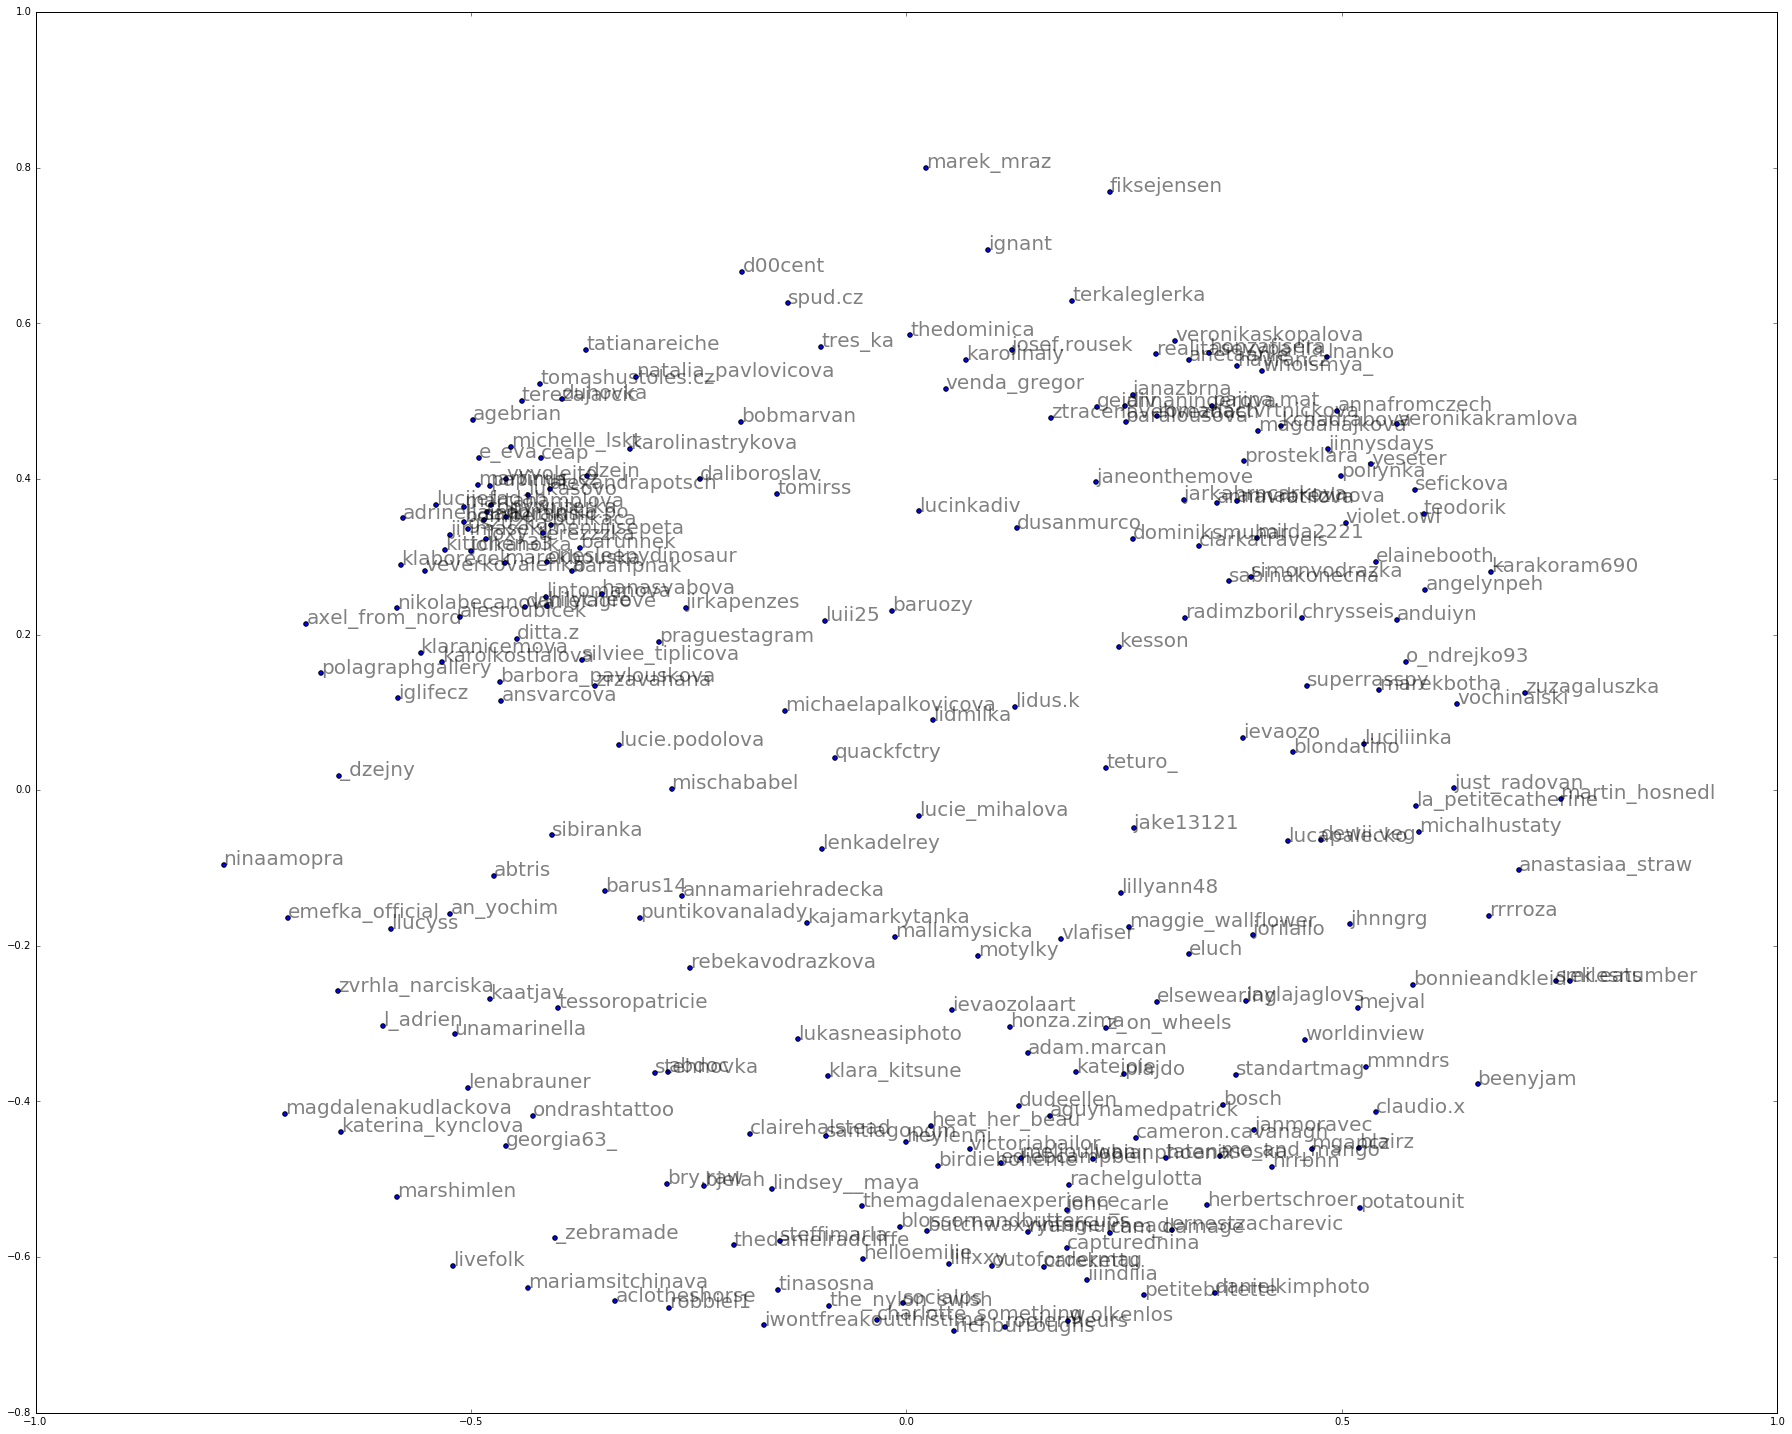

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import MDS

from sklearn.metrics.pairwise import cosine_similarity

# we need distance, not similarity
dist = 1 - cosine_similarity(dtm)
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(dist)  # shape (n_components, n_samples)


plt.figure(figsize=(25, 20))  # use a bigger canvas than usual

xs, ys = pos[:, 0], pos[:, 1]


plt.scatter(xs, ys)

for x, y, name in zip(xs, ys, usernames):
    plt.text(x, y, name, alpha=0.5, fontsize=20)

plt.tight_layout()


### User distance between two users



In [5]:
from sklearn.metrics.pairwise import euclidean_distances

dist = euclidean_distances(dtm)

np.round(dist, 1)

array([[   0. ,  131.6,  121.3, ...,   67.8,   34. ,  427.7],
       [ 131.6,    0. ,  122.6, ...,  148.2,  129.8,  446.2],
       [ 121.3,  122.6,    0. , ...,  139.1,  118.4,  442.9],
       ..., 
       [  67.8,  148.2,  139.1, ...,    0. ,   68.8,  431.3],
       [  34. ,  129.8,  118.4, ...,   68.8,    0. ,  426.7],
       [ 427.7,  446.2,  442.9, ...,  431.3,  426.7,    0. ]])

In [6]:
# I don't want to see media from this account
dist[usernames.index('josef.rousek'), usernames.index('emefka_official')]

416.97961580873471

In [7]:
# This one is fine
dist[usernames.index('josef.rousek'), usernames.index('iglifecz')]

248.10078597215286

In [8]:
# This one is fine
dist[usernames.index('josef.rousek'), usernames.index('motylky')]

215.57829204258948

In [9]:
# Calculate threshold
np.mean(dist) * 2

370.18486853201443